In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Load Data

In [2]:
train_data = pd.read_csv('data/train.csv')
pd.set_option('display.max_rows', 20)
display(train_data)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Display Digits

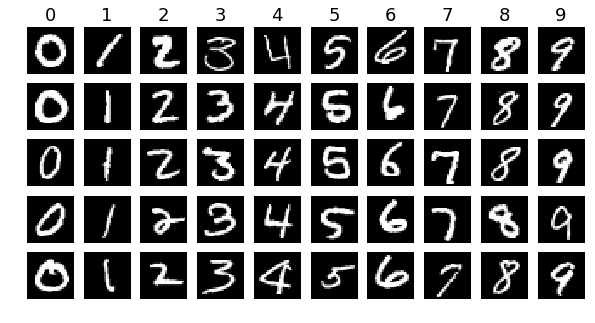

In [3]:
digit_num = 10
samples = 5
plt.gcf().set_size_inches(10, samples)

for i in range(digit_num):
    digits = train_data.loc[train_data['label'] == i].iloc[:, 1:]
    for j in range(samples):
        plt_idx = i + 1 + j * digit_num 
        plt.subplot(samples, digit_num, plt_idx)
        plt.imshow(digits.iloc[j].values.reshape(28, 28), cmap='gray')
        plt.axis("off")
        if j == 0:
            plt.title(i, fontsize=18)

## Prior Possibilities

manual: [0.09838095238095237, 0.11152380952380953, 0.09945238095238096, 0.1035952380952381, 0.09695238095238096, 0.09035714285714286, 0.0985, 0.10478571428571429, 0.09673809523809523, 0.09971428571428571]


(array([0.09838095, 0.11152381, 0.09945238, 0.10359524, 0.09695238,
        0.09035714, 0.0985    , 0.10478571, 0.0967381 , 0.09971429]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

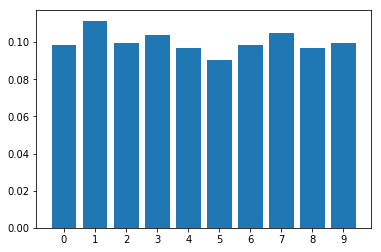

In [4]:
# Manual
prior_possibilities = [len(train_data.loc[train_data['label'] == i]) / train_data.shape[0] for i in range(digit_num)]
print("manual:", prior_possibilities)

# Plot
plt.xticks(range(digit_num))
plt.hist(train_data['label'], bins=range(digit_num + 1), density=1, align='left', rwidth=0.8)